In [1]:
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath('..'))
import numpy as np
import matplotlib.pyplot as plt
import json
import os

from src.recommender import (
    create_user_item_matrix,
    compute_similarity,
    get_top_n_recommendations,
    save_top_n_all_users,
    predict_rating_user_based,
    predict_rating_item_based
)

In [2]:
df = pd.read_csv("../data/ratings_merged.csv")

In [3]:
ratings_matrix = create_user_item_matrix(df)

In [4]:
user_similarity = compute_similarity(ratings_matrix, kind='user')
item_similarity = compute_similarity(ratings_matrix, kind='item')

In [5]:
def compute_rmse(ratings_matrix, similarity_matrix, kind='user', sample_size=1000):
    true_ratings = []
    predicted_ratings = []

    sampled = ratings_matrix.stack().sample(sample_size, random_state=42)
    for (user_id, item_id), true_rating in sampled.items():
        if kind == 'user':
            pred = predict_rating_user_based(user_id, item_id, ratings_matrix, similarity_matrix)
        else:
            pred = predict_rating_item_based(user_id, item_id, ratings_matrix, similarity_matrix)
        
        if not np.isnan(pred):
            true_ratings.append(true_rating)
            predicted_ratings.append(pred)

    mse = np.mean((np.array(true_ratings) - np.array(predicted_ratings)) ** 2)
    return np.sqrt(mse)

In [6]:
print("Evaluating User-Based CF...")
user_rmse = compute_rmse(ratings_matrix, user_similarity, kind='user')
print(f"User-Based RMSE: {user_rmse:.4f}")

print("Evaluating Item-Based CF...")
item_rmse = compute_rmse(ratings_matrix, item_similarity, kind='item')
print(f"Item-Based RMSE: {item_rmse:.4f}")

Evaluating User-Based CF...
User-Based RMSE: 3.0758
Evaluating Item-Based CF...
Item-Based RMSE: 3.5872


In [10]:
os.makedirs("../results", exist_ok=True)
with open("../results/evaluation_metrics.json", "w") as f:
    json.dump({
        "user_based_rmse": user_rmse,
        "item_based_rmse": item_rmse
    }, f, indent=4)

In [11]:
save_top_n_all_users(ratings_matrix, user_similarity, kind='user', n=10)

Saved recommendations to ../results/top_n_recommendations.csv


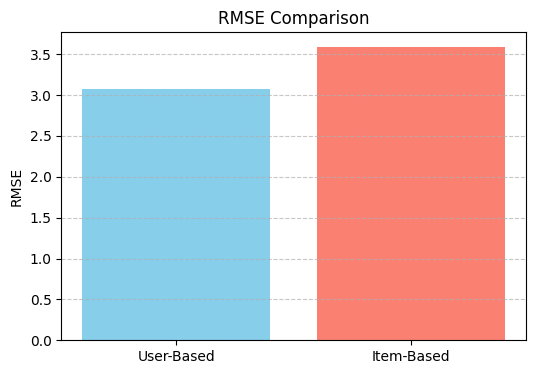

In [7]:
labels = ['User-Based', 'Item-Based']
rmse_values = [user_rmse, item_rmse]

plt.figure(figsize=(6, 4))
plt.bar(labels, rmse_values, color=['skyblue', 'salmon'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [8]:
from src.evaluation import evaluate_precision_recall
from src.recommender import get_top_n_recommendations

avg_prec, avg_rec = evaluate_precision_recall(
    df=df,
    ratings_matrix=ratings_matrix,
    similarity_matrix=user_similarity,
    kind='user',
    k=10,
    n_users=100,
    get_top_n_func=get_top_n_recommendations
)

print(f"Precision@10: {avg_prec:.4f}")
print(f"Recall@10: {avg_rec:.4f}")

Precision@10: 0.0020
Recall@10: 0.0006
